In [43]:
# Import necessary libraries
import os
import torch
import torchaudio
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import normalize
from transformers import Wav2Vec2FeatureExtractor, WavLMModel
from peft import LoraConfig, get_peft_model, TaskType
import soundfile as sf
import pickle
import shutil
import zipfile
from google.colab import drive

In [2]:
# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
folder = '/content/drive/MyDrive/SU_Assignment_2'
shared_vox1 = f'{folder}/vox1/vox1_test_wav.zip'
shared_vox2_audio = f'{folder}/vox2/vox2_test_aac-002.zip'
shared_vox2_txt = f'{folder}/vox2/vox2_test_txt.zip'

In [6]:
os.makedirs('/content/voxceleb_data/vox1', exist_ok = True)
os.makedirs('/content/voxceleb_data/vox2_aac', exist_ok = True)
os.makedirs('/content/voxceleb_data/vox2_txt', exist_ok = True)

In [7]:
# Copy files from Drive to local Colab VM
shutil.copy(shared_vox1, "/content/")
shutil.copy(shared_vox2_audio, "/content/")
shutil.copy(shared_vox2_txt, "/content/")

'/content/vox2_test_txt.zip'

In [8]:
# Extract zip files with full paths
zips_and_targets = {
    "/content/vox1_test_wav.zip": "/content/voxceleb_data/vox1",
    "/content/vox2_test_aac-002.zip": "/content/voxceleb_data/vox2_aac",
    "/content/vox2_test_txt.zip": "/content/voxceleb_data/vox2_txt"
}

for zip_file, target_dir in zips_and_targets.items():
    print(f"Extracting {zip_file} to {target_dir}...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f"Done extracting {zip_file}")

Extracting /content/vox1_test_wav.zip to /content/voxceleb_data/vox1...
Done extracting /content/vox1_test_wav.zip
Extracting /content/vox2_test_aac-002.zip to /content/voxceleb_data/vox2_aac...
Done extracting /content/vox2_test_aac-002.zip
Extracting /content/vox2_test_txt.zip to /content/voxceleb_data/vox2_txt...
Done extracting /content/vox2_test_txt.zip


In [9]:
# Convert VoxCeleb2 AAC files to WAV format
aac_root = "/content/voxceleb_data/vox2_aac/aac"
wav_root = "/content/voxceleb_data/vox2_wav"
os.makedirs(wav_root, exist_ok=True)

# Get speaker directories
speaker_dirs = sorted(os.listdir(aac_root))[:118]
print(f"Total speakers (VoxCeleb2): {len(speaker_dirs)}")

for speaker in tqdm(speaker_dirs, desc="Converting AAC to WAV"):
    speaker_path = os.path.join(aac_root, speaker)
    for root, _, files in os.walk(speaker_path):
        for file in files:
            if file.endswith(".m4a"):
                m4a_path = os.path.join(root, file)
                relative_path = os.path.relpath(m4a_path, aac_root)
                wav_path = os.path.join(wav_root, relative_path.replace(".m4a", ".wav"))
                os.makedirs(os.path.dirname(wav_path), exist_ok=True)
                try:
                    waveform, sr = torchaudio.load(m4a_path)
                    torchaudio.save(wav_path, waveform, sr)
                except Exception as e:
                    print(f"Skipped {m4a_path} — {e}")
print("Finished converting VoxCeleb2 AAC files to WAV.")

Total speakers (VoxCeleb2): 118


Converting AAC to WAV: 100%|██████████| 118/118 [06:00<00:00,  3.06s/it]

Finished converting VoxCeleb2 AAC files to WAV.


In [10]:
def download_verification_list():
    !wget https://mm.kaist.ac.kr/datasets/voxceleb/meta/veri_test.txt -O /content/veri_test.txt
    return "/content/veri_test.txt"

# Download verification list
veri_txt_path = download_verification_list()

--2025-04-06 14:05:23--  https://mm.kaist.ac.kr/datasets/voxceleb/meta/veri_test.txt
Resolving mm.kaist.ac.kr (mm.kaist.ac.kr)... 143.248.39.47
Connecting to mm.kaist.ac.kr (mm.kaist.ac.kr)|143.248.39.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2338640 (2.2M) [text/plain]
Saving to: ‘/content/veri_test.txt’

/content/veri_test. 100%[===================>]   2.23M   424KB/s    in 6.0s    

2025-04-06 14:05:30 (382 KB/s) - ‘/content/veri_test.txt’ saved [2338640/2338640]



In [11]:
# Load the processed data
def load_processed_data(data_path='/content/voxceleb_data_info.pkl'):
    with open(data_path, 'rb') as f:
        data_info = pickle.load(f)

    print(f"Loaded processed data with {len(data_info['train_samples'])} training samples")
    return data_info

In [12]:
# Helper functions for loading and processing audio
def load_audio(path, target_sr=16000):
    try:
        waveform, sample_rate = torchaudio.load(path)
        if waveform.shape[0] > 1:  # Convert stereo to mono if needed
            waveform = waveform.mean(dim=0, keepdim=True)
        if sample_rate != target_sr:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
            waveform = resampler(waveform)
        return waveform.squeeze(0)  # Return as torch.Tensor
    except Exception as e:
        print(f"Error loading {path}: {e}")
        # Fallback to soundfile if torchaudio fails
        audio, sr = sf.read(path)
        if sr != target_sr:
            raise ValueError("Resampling not implemented for fallback method.")
        return torch.tensor(audio, dtype=torch.float32)

In [13]:
class VoxCelebDataset(Dataset):
    def __init__(self, samples, sample_rate=16000, max_length=48000, feature_extractor=None):
        self.samples = samples
        self.sample_rate = sample_rate
        self.max_length = max_length  # 3 seconds at 16kHz
        self.feature_extractor = feature_extractor

        # Find the maximum label for num_classes
        self.num_classes = max([label for _, label in samples]) + 1
        print(f"Dataset initialized with {len(samples)} samples and {self.num_classes} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        waveform = load_audio(path, target_sr=self.sample_rate)

        # Normalize the waveform
        waveform = waveform / (torch.max(torch.abs(waveform)) + 1e-8)

        # Clip or pad to max_length
        if waveform.shape[0] > self.max_length:
            # Randomly sample a segment of max_length
            start = random.randint(0, waveform.shape[0] - self.max_length)
            waveform = waveform[start:start + self.max_length]
        else:
            # Pad with zeros
            padded = torch.zeros(self.max_length)
            padded[:waveform.shape[0]] = waveform
            waveform = padded

        if self.feature_extractor is not None:
            inputs = self.feature_extractor(
                waveform,
                sampling_rate=self.sample_rate,
                return_tensors="pt"
            )
            return inputs.input_values.squeeze(0), label

        return waveform, label

In [14]:
def create_dataloader(samples, batch_size=8, feature_extractor=None, shuffle=True):
    dataset = VoxCelebDataset(samples, feature_extractor=feature_extractor)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True
    )
    return dataloader, dataset.num_classes

In [15]:
# Verification utilities
class VerificationDataset(Dataset):
    def __init__(self, verification_pairs, sample_rate=16000, max_length=48000, feature_extractor=None):
        self.verification_pairs = verification_pairs
        self.sample_rate = sample_rate
        self.max_length = max_length
        self.feature_extractor = feature_extractor
        print(f"Verification dataset initialized with {len(verification_pairs)} pairs")

    def __len__(self):
        return len(self.verification_pairs)

    def __getitem__(self, idx):
        path1, path2, label = self.verification_pairs[idx]

        # Load and process audio 1
        waveform1 = load_audio(path1, target_sr=self.sample_rate)
        waveform1 = waveform1 / (torch.max(torch.abs(waveform1)) + 1e-8)

        # Clip or pad audio 1
        if waveform1.shape[0] > self.max_length:
            waveform1 = waveform1[:self.max_length]
        else:
            padded1 = torch.zeros(self.max_length)
            padded1[:waveform1.shape[0]] = waveform1
            waveform1 = padded1

        # Load and process audio 2
        waveform2 = load_audio(path2, target_sr=self.sample_rate)
        waveform2 = waveform2 / (torch.max(torch.abs(waveform2)) + 1e-8)

        # Clip or pad audio 2
        if waveform2.shape[0] > self.max_length:
            waveform2 = waveform2[:self.max_length]
        else:
            padded2 = torch.zeros(self.max_length)
            padded2[:waveform2.shape[0]] = waveform2
            waveform2 = padded2

        if self.feature_extractor is not None:
            inputs1 = self.feature_extractor(
                waveform1,
                sampling_rate=self.sample_rate,
                return_tensors="pt"
            ).input_values.squeeze(0)

            inputs2 = self.feature_extractor(
                waveform2,
                sampling_rate=self.sample_rate,
                return_tensors="pt"
            ).input_values.squeeze(0)

            return inputs1, inputs2, label

        return waveform1, waveform2, label

In [16]:
def create_verification_dataloader(verification_pairs, batch_size=8, feature_extractor=None):
    dataset = VerificationDataset(verification_pairs, feature_extractor=feature_extractor)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    return dataloader

In [17]:
#WaveLM Speaker Recognition Model
class WaveLMSpeakerModel(nn.Module):
    def __init__(self, num_classes, pretrained_model_name="microsoft/wavlm-base-plus"):
        super(WaveLMSpeakerModel, self).__init__()

        # Load the pre-trained WaveLM model
        self.wavlm = WavLMModel.from_pretrained(pretrained_model_name)

        # Feature dimension from WaveLM base-plus
        wavlm_dim = self.wavlm.config.hidden_size  # 768 for WaveLM base plus

        # Speaker embedding network
        self.speaker_embedding = nn.Sequential(
            nn.Linear(wavlm_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256)
        )

        # Classification layer
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x, extract_embedding=False):
        # Get WaveLM features
        with torch.no_grad():
            outputs = self.wavlm(x)
            # Use the last hidden state
            wavlm_features = outputs.last_hidden_state

        # Mean pooling over time dimension
        pooled_features = torch.mean(wavlm_features, dim=1)

        # Speaker embedding
        embedding = self.speaker_embedding(pooled_features)

        # Return the embedding if requested (for verification)
        if extract_embedding:
            return embedding

        # Classification for identification
        logits = self.classifier(embedding)
        return logits, embedding

In [18]:
# Siamese network for verification tasks
class SiameseSpeakerVerifier(nn.Module):
    def __init__(self, embedding_model):
        super(SiameseSpeakerVerifier, self).__init__()
        self.embedding_model = embedding_model

    def forward(self, x1, x2):
        # Extract embeddings from both inputs
        embedding1 = self.embedding_model(x1, extract_embedding=True)
        embedding2 = self.embedding_model(x2, extract_embedding=True)

        # Compute cosine similarity
        embedding1_norm = F.normalize(embedding1, p=2, dim=1)
        embedding2_norm = F.normalize(embedding2, p=2, dim=1)
        cosine_similarity = torch.sum(embedding1_norm * embedding2_norm, dim=1)

        return cosine_similarity, embedding1, embedding2

In [19]:
# Initializing the WaveLM model with LoRA
def init_wavelm_with_lora(num_classes):
    # LoRA configuration
    peft_config = LoraConfig(
        task_type=TaskType.FEATURE_EXTRACTION,
        inference_mode=False,
        r=8,  # Rank of the low-rank matrices
        lora_alpha=16,  # Scaling factor for the low-rank matrices
        lora_dropout=0.1,
        target_modules=["k_proj", "q_proj", "v_proj"]  # Target attention modules
    )

    # Initializing the base model
    base_model = WaveLMSpeakerModel(num_classes)

    # Applying LoRA to the model
    peft_model = get_peft_model(base_model, peft_config)
    print(f"Model initialized with LoRA for efficient fine-tuning")

    return peft_model

In [20]:
# Training functions
def train_epoch(model, dataloader, optimizer, criterion, scheduler, device, epoch):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for i, (inputs, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1} Training")):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        logits, _ = model(inputs)
        loss = criterion(logits, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update learning rate
        if scheduler is not None:
            scheduler.step()

        # Statistics
        running_loss += loss.item()

        # Compute accuracy
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        if (i + 1) % 10 == 0:
            print(f'Step {i+1}/{len(dataloader)}, Loss: {loss.item():.4f}')

    # Calculate epoch statistics
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

In [21]:
def evaluate(model, dataloader, criterion, device, desc="Evaluation"):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=desc):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            logits, _ = model(inputs)
            loss = criterion(logits, labels)

            # Statistics
            running_loss += loss.item()

            # Compute accuracy
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    eval_loss = running_loss / len(dataloader)
    eval_acc = accuracy_score(all_labels, all_preds)

    # Additional metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    return eval_loss, eval_acc, precision, recall, f1

In [22]:
# Verification evaluation functions
def evaluate_verification(model, verifier, dataloader, device, threshold=0.5):
    model.eval()
    verifier.eval()

    all_scores = []
    all_labels = []

    with torch.no_grad():
        for x1, x2, labels in tqdm(dataloader, desc="Verification Evaluation"):
            x1, x2 = x1.to(device), x2.to(device)

            # Calculate similarity scores
            scores, _, _ = verifier(x1, x2)

            # Collect results
            all_scores.extend(scores.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)

    # Calculate EER and other metrics
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    fnr = 1 - tpr

    # Find the threshold where FPR = FNR (EER point)
    eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

    # Calculate ROC AUC
    roc_auc = auc(fpr, tpr)

    # Calculate verification accuracy using the provided threshold
    pred_labels = (all_scores >= threshold).astype(int)
    acc = accuracy_score(all_labels, pred_labels)

    # Calculate verification accuracy using the EER threshold
    pred_labels_eer = (all_scores >= eer_threshold).astype(int)
    acc_eer = accuracy_score(all_labels, pred_labels_eer)

    return {
        "eer": eer,
        "eer_threshold": eer_threshold,
        "auc": roc_auc,
        "accuracy": acc,
        "accuracy_eer": acc_eer,
        "scores": all_scores,
        "labels": all_labels,
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds
    }

In [23]:
def evaluate_speaker_identification(model, data_info, batch_size=8, save_dir='/content/plots'):
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    print("Evaluating speaker identification accuracy...")

    # Initialize feature extractor
    model_name = model.encoder.name_or_path if hasattr(model, 'encoder') else "microsoft/wavlm-base-plus"
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

    # Create test dataloader
    test_loader, num_classes = create_dataloader(
        data_info['test_samples'],
        batch_size=batch_size,
        feature_extractor=feature_extractor,
        shuffle=False
    )

    # Set model to evaluation mode
    model.eval()

    # Evaluate on test set
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Speaker ID Evaluation"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            if hasattr(model, 'classifier'):
                logits, _ = model(inputs)
                preds = torch.argmax(logits, dim=1)
            else:
                embeddings = model(inputs, extract_embedding=True)
                preds = torch.zeros_like(labels)

            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    # Create confusion matrix (for top N classes if there are many)
    top_n = min(20, num_classes)  # Show at most 20 classes
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds)

    # If there are too many classes, select the top N most common ones
    if num_classes > top_n:
        label_counts = np.bincount(all_labels)
        top_indices = np.argsort(label_counts)[-top_n:]
        cm_subset = cm[top_indices, :][:, top_indices]

        # Create labels for the confusion matrix
        cm_labels = [f"Speaker {i}" for i in top_indices]
    else:
        cm_subset = cm
        cm_labels = [f"Speaker {i}" for i in range(num_classes)]

    # Plot confusion matrix
    plt.imshow(cm_subset, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Speaker Identification Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(cm_labels))
    plt.xticks(tick_marks, cm_labels, rotation=45)
    plt.yticks(tick_marks, cm_labels)
    plt.xlabel('Predicted Speaker')
    plt.ylabel('True Speaker')
    plt.tight_layout()

    # Save the confusion matrix
    plt.savefig(f'{save_dir}/speaker_id_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print results
    print(f"Speaker Identification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [24]:
# Function to visualize training progress
def plot_training_progress(train_losses, val_losses, train_accs, val_accs, save_dir='/content/plots'):
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{save_dir}/training_progress.png', dpi=300, bbox_inches='tight')
    plt.show()

In [25]:
# Function to plot verification ROC curve
def plot_verification_roc(fpr, tpr, roc_auc, eer, save_dir='/content/plots'):
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Mark the EER point
    eer_idx = np.nanargmin(np.absolute(1 - tpr - fpr))
    plt.scatter(fpr[eer_idx], tpr[eer_idx], marker='o', color='red',
                label=f'EER = {eer:.3f}')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)

    # Save the figure
    plt.savefig(f'{save_dir}/verification_roc.png', dpi=300, bbox_inches='tight')
    plt.show()

In [26]:
# Main execution function for training
def train_wavelm_speaker_recognition(data_info, batch_size=8, num_epochs=4, learning_rate=1e-4,
                                    save_dir='/content/model_checkpoints'):
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # Initialize feature extractor
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")

    # Create dataloaders
    train_loader, num_classes = create_dataloader(
        data_info['train_samples'],
        batch_size=batch_size,
        feature_extractor=feature_extractor,
        shuffle=True
    )

    test_loader, _ = create_dataloader(
        data_info['test_samples'],
        batch_size=batch_size,
        feature_extractor=feature_extractor,
        shuffle=False
    )

    # Initialize the model with LoRA
    model = init_wavelm_with_lora(num_classes)
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Learning rate scheduler
    total_steps = len(train_loader) * num_epochs
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

    # Training loop
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Train for one epoch
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, criterion, scheduler, device, epoch
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluate on validation set
        val_loss, val_acc, precision, recall, f1 = evaluate(
            model, test_loader, criterion, device, desc="Validation"
        )
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{save_dir}/wavelm_speaker_best.pt")
            print(f"Saved best model with validation accuracy: {val_acc:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_losses': val_losses,
            'val_accs': val_accs,
            'best_val_acc': best_val_acc
        }, f"{save_dir}/wavelm_speaker_checkpoint.pt")

    # Plot training progress
    plot_training_progress(train_losses, val_losses, train_accs, val_accs)

    # Load best model for final evaluation
    model.load_state_dict(torch.load(f"{save_dir}/wavelm_speaker_best.pt"))

    # Final evaluation
    final_loss, final_acc, precision, recall, f1 = evaluate(
        model, test_loader, criterion, device, desc="Final Evaluation"
    )

    print(f"\nFinal Results:")
    print(f"Test Loss: {final_loss:.4f}, Test Accuracy: {final_acc:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return model, {
        'final_acc': final_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }

In [27]:
# Speaker verification task using the trained model
def perform_speaker_verification(data_info, model, batch_size=8):
    # Initialize feature extractor
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")

    # Create verification dataloader
    verification_loader = create_verification_dataloader(
        data_info['verification_pairs'][:5000],  # Using a subset for faster evaluation
        batch_size=batch_size,
        feature_extractor=feature_extractor
    )

    # Initialize the verification model (Siamese network)
    verifier = SiameseSpeakerVerifier(model)
    verifier.to(device)

    # Evaluate verification performance
    verification_results = evaluate_verification(
        model, verifier, verification_loader, device, threshold=0.5
    )

    # Print results
    print(f"\nVerification Results:")
    print(f"EER: {verification_results['eer']:.4f}")
    print(f"AUC: {verification_results['auc']:.4f}")
    print(f"Accuracy (threshold=0.5): {verification_results['accuracy']:.4f}")
    print(f"Accuracy (threshold={verification_results['eer_threshold']:.4f}): {verification_results['accuracy_eer']:.4f}")

    # Plot ROC curve
    plot_verification_roc(
        verification_results['fpr'],
        verification_results['tpr'],
        verification_results['auc'],
        verification_results['eer']
    )

    return verification_results

In [28]:
# ArcFace Loss Implementation
class ArcFaceLoss(nn.Module):
    def __init__(self, embedding_size, num_classes, s=30.0, m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        # Normalize weights
        normalized_weights = F.normalize(self.weight, p=2, dim=1)

        # Normalize embeddings
        normalized_embeddings = F.normalize(embeddings, p=2, dim=1)

        # Cosine similarity
        cos_theta = F.linear(normalized_embeddings, normalized_weights)

        # Clip to prevent NaN
        cos_theta = torch.clamp(cos_theta, -1.0 + 1e-7, 1.0 - 1e-7)

        # Calculate arc cosine
        theta = torch.acos(cos_theta)

        # Add margin
        target_logits = torch.cos(theta + self.m)

        # Create one-hot encoding for target logits
        one_hot = torch.zeros_like(cos_theta)
        one_hot.scatter_(1, labels.view(-1, 1), 1)

        # Apply margin to target logits only
        output = torch.where(one_hot == 1, target_logits, cos_theta)

        # Scale by s
        output = output * self.s

        return output, one_hot

In [29]:
# Enhanced verification metrics calculation
def calculate_verification_metrics(scores, labels):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)

    # Calculate EER
    fnr = 1 - tpr
    eer_idx = np.argmin(np.abs(fpr - fnr))
    eer = (fpr[eer_idx] + fnr[eer_idx]) / 2
    eer_threshold = thresholds[eer_idx]

    # Calculate TAR@1%FAR (True Accept Rate at 1% False Accept Rate)
    tar_at_far_idx = np.argmin(np.abs(fpr - 0.01))
    tar_at_far = tpr[tar_at_far_idx]
    tar_at_far_threshold = thresholds[tar_at_far_idx]

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Format metrics
    eer_percent = eer * 100
    tar_at_far_percent = tar_at_far * 100

    return {
        "eer": eer,
        "eer_percent": eer_percent,
        "eer_threshold": eer_threshold,
        "tar_at_far": tar_at_far,
        "tar_at_far_percent": tar_at_far_percent,
        "tar_at_far_threshold": tar_at_far_threshold,
        "auc": roc_auc,
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds
    }

In [30]:
# Enhanced evaluation function for verification
def enhanced_evaluate_verification(model, verifier, dataloader, device):
    model.eval()
    verifier.eval()

    all_scores = []
    all_labels = []

    with torch.no_grad():
        for x1, x2, labels in tqdm(dataloader, desc="Verification Evaluation"):
            x1, x2 = x1.to(device), x2.to(device)

            # Calculate similarity scores
            scores, _, _ = verifier(x1, x2)

            # Collect results
            all_scores.extend(scores.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)

    # Calculate all metrics
    metrics = calculate_verification_metrics(all_scores, all_labels)

    # Add raw predictions for further analysis
    metrics["scores"] = all_scores
    metrics["labels"] = all_labels

    return metrics

In [31]:
# Modified Speaker Recognition Model with ArcFace support
class SpeakerRecognitionModel(nn.Module):
    def __init__(self, num_classes, model_name="microsoft/wavlm-base-plus", embedding_size=256):
        super(SpeakerRecognitionModel, self).__init__()

        # Load the pre-trained model
        self.encoder = WavLMModel.from_pretrained(model_name)

        # Feature dimension
        hidden_size = self.encoder.config.hidden_size

        # Speaker embedding network
        self.speaker_embedding = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, embedding_size)
        )

        # For standard cross-entropy loss
        self.classifier = nn.Linear(embedding_size, num_classes)

        # For ArcFace
        self.use_arcface = False
        self.arcface = None
        self.num_classes = num_classes
        self.embedding_size = embedding_size

    def enable_arcface(self, s=30.0, m=0.5):
        self.use_arcface = True
        self.arcface = ArcFaceLoss(self.embedding_size, self.num_classes, s, m)

    def disable_arcface(self):
        self.use_arcface = False

    def forward(self, x, labels=None, extract_embedding=False):

        # Get encoder features
        with torch.no_grad():
            outputs = self.encoder(x)
            features = outputs.last_hidden_state

        # Mean pooling over time dimension
        pooled_features = torch.mean(features, dim=1)

        # Speaker embedding
        embedding = self.speaker_embedding(pooled_features)

        # Return the embedding if requested (for verification)
        if extract_embedding:
            return embedding

        # If using ArcFace and labels are provided
        if self.use_arcface and labels is not None:
            logits, _ = self.arcface(embedding, labels)
            return logits, embedding
        # Standard classification
        else:
            logits = self.classifier(embedding)
            return logits, embedding

In [32]:
# Functions to compare pre-trained and fine-tuned models
def evaluate_pretrained_model(data_info, model_name="microsoft/wavlm-base-plus", batch_size=8, save_dir='/content/plots'):
    print(f"Evaluating pre-trained model: {model_name}")
    feature_extractor = None

    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

     # Create verification pairs
    verification_pairs = data_info['verification_pairs'][:5000]  # Using subset for faster evaluation

    # Initialize model
    num_classes = 100
    model = SpeakerRecognitionModel(num_classes, model_name=model_name)
    model.to(device)

    # Initialize the verification model
    verifier = SiameseSpeakerVerifier(model)
    verifier.to(device)

 # Create metrics to track
    subset_sizes = [500, 1000, 2000, 3000, 4000, 5000]
    metrics_by_subset = []

    for size in tqdm(subset_sizes, desc="Evaluating subsets"):
        # Create dataloader for this subset
        subset_loader = create_verification_dataloader(
            verification_pairs[:size],
            batch_size=batch_size,
            feature_extractor=feature_extractor
        )

        # Evaluate on this subset
        metrics = enhanced_evaluate_verification(model, verifier, subset_loader, device)
        metrics['subset_size'] = size
        metrics_by_subset.append(metrics)


    # Plot results
    plt.figure(figsize=(15, 10))

    # Plot EER across subset sizes
    plt.subplot(2, 2, 1)
    plt.plot([m['subset_size'] for m in metrics_by_subset],
             [m['eer_percent'] for m in metrics_by_subset], 'b-o')
    plt.title('EER vs. Dataset Size')
    plt.xlabel('Number of Verification Pairs')
    plt.ylabel('EER (%)')
    plt.grid(True)

    # Plot AUC across subset sizes
    plt.subplot(2, 2, 2)
    plt.plot([m['subset_size'] for m in metrics_by_subset],
             [m['auc'] for m in metrics_by_subset], 'r-o')
    plt.title('AUC vs. Dataset Size')
    plt.xlabel('Number of Verification Pairs')
    plt.ylabel('AUC')
    plt.grid(True)

    # Plot TAR@1%FAR across subset sizes
    plt.subplot(2, 2, 3)
    plt.plot([m['subset_size'] for m in metrics_by_subset],
             [m['tar_at_far_percent'] for m in metrics_by_subset], 'g-o')
    plt.title('TAR@1%FAR vs. Dataset Size')
    plt.xlabel('Number of Verification Pairs')
    plt.ylabel('TAR@1%FAR (%)')
    plt.grid(True)

    # Plot final ROC curve
    plt.subplot(2, 2, 4)
    final_metrics = metrics_by_subset[-1]  # Get the last (largest) subset
    plt.plot(final_metrics['fpr'], final_metrics['tpr'], 'b-')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (AUC = {final_metrics["auc"]:.3f})')
    plt.grid(True)

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{save_dir}/pretrained_model_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print final results
    print(f"\nPre-trained Model Verification Results (Full Dataset):")
    print(f"EER: {final_metrics['eer_percent']:.2f}%")
    print(f"TAR@1%FAR: {final_metrics['tar_at_far_percent']:.2f}%")
    print(f"AUC: {final_metrics['auc']:.4f}")

    # Add speaker identification evaluation
    speaker_id_metrics = evaluate_speaker_identification(model, data_info, batch_size, save_dir)

    # Add speaker ID metrics to the returned metrics
    final_metrics.update({
        'speaker_id_accuracy': speaker_id_metrics['accuracy'],
        'speaker_id_precision': speaker_id_metrics['precision'],
        'speaker_id_recall': speaker_id_metrics['recall'],
        'speaker_id_f1': speaker_id_metrics['f1']
    })

    return final_metrics

In [33]:
def fine_tune_with_arcface(data_info, model_name="microsoft/wavlm-base-plus",
                          batch_size=8, num_epochs=3, learning_rate=5e-4,
                          save_dir='/content/model_checkpoints'):
    print(f"Fine-tuning model with ArcFace loss: {model_name}")

    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # Initialize feature extractor
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

    # Create dataloaders
    train_loader, num_classes = create_dataloader(
        data_info['train_samples'],
        batch_size=batch_size,
        feature_extractor=feature_extractor,
        shuffle=True
    )

    test_loader, _ = create_dataloader(
        data_info['test_samples'],
        batch_size=batch_size,
        feature_extractor=feature_extractor,
        shuffle=False
    )

    # Initialize the model
    model = SpeakerRecognitionModel(num_classes, model_name=model_name)

    # Apply LoRA
    peft_config = LoraConfig(
        inference_mode=False,
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=["k_proj", "q_proj", "v_proj"]
    )
    model = get_peft_model(model, peft_config)

    # Enable ArcFace loss
    model.enable_arcface(s=30.0, m=0.5)
    model.to(device)

    # Define optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # Learning rate scheduler
    total_steps = len(train_loader) * num_epochs
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

    # Training loop
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            logits, _ = model(inputs, labels)

            # Cross entropy loss (already applied in ArcFace)
            loss = F.cross_entropy(logits, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update scheduler
            if scheduler is not None:
                scheduler.step()

            # Statistics
            running_loss += loss.item()

            # Compute accuracy
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

            if (i + 1) % 10 == 0:
                print(f'Step {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = accuracy_score(all_labels, all_preds)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_all_preds = []
        val_all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                logits, _ = model(inputs)
                loss = F.cross_entropy(logits, labels)

                # Statistics
                val_running_loss += loss.item()

                # Compute accuracy
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                val_all_preds.extend(preds)
                val_all_labels.extend(labels.cpu().numpy())

        # Calculate validation statistics
        val_loss = val_running_loss / len(test_loader)
        val_acc = accuracy_score(val_all_labels, val_all_preds)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{save_dir}/model_arcface_best.pt")
            print(f"Saved best model with validation accuracy: {val_acc:.4f}")

    # Plot training progress
    plot_training_progress(train_losses, val_losses, train_accs, val_accs)

    # Load best model
    model.load_state_dict(torch.load(f"{save_dir}/model_arcface_best.pt"))

    return model

In [34]:
def evaluate_finetuned_model(data_info, model, batch_size=8, save_dir='/content/plots'):
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    print("Evaluating fine-tuned model on verification task")

    # Get appropriate feature extractor
    model_name = model.encoder.name_or_path if hasattr(model, 'encoder') else "microsoft/wavlm-base-plus"
    feature_extractor = None

    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

    # Create verification dataloader
    verification_loader = create_verification_dataloader(
        data_info['verification_pairs'],
        batch_size=batch_size,
        feature_extractor=feature_extractor
    )

    # Initialize the verification model
    verifier = SiameseSpeakerVerifier(model)
    verifier.to(device)

    # Evaluate
    metrics = enhanced_evaluate_verification(model, verifier, verification_loader, device)

    # Print results
    print(f"\nFine-tuned Model Verification Results:")
    print(f"EER: {metrics['eer_percent']:.2f}%")
    print(f"TAR@1%FAR: {metrics['tar_at_far_percent']:.2f}%")
    print(f"AUC: {metrics['auc']:.4f}")

    # Plot ROC curve and save
    plot_verification_roc(
        metrics['fpr'],
        metrics['tpr'],
        metrics['auc'],
        metrics['eer'],
        save_dir=save_dir
    )

    # Add speaker identification evaluation
    speaker_id_metrics = evaluate_speaker_identification(model, data_info, batch_size, save_dir)

    # Add speaker ID metrics to the returned metrics
    metrics.update({
        'speaker_id_accuracy': speaker_id_metrics['accuracy'],
        'speaker_id_precision': speaker_id_metrics['precision'],
        'speaker_id_recall': speaker_id_metrics['recall'],
        'speaker_id_f1': speaker_id_metrics['f1']
    })

    return metrics

In [35]:
def compare_models(pretrained_metrics, finetuned_metrics, save_dir='/content/plots'):
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    print("\n" + "="*50)
    print("Model Performance Comparison")
    print("="*50)

    print(f"{'Metric':<15} {'Pre-trained':<15} {'Fine-tuned':<15} {'Improvement':<15}")
    print("-"*60)

    # EER (lower is better)
    eer_pretrained = pretrained_metrics['eer_percent']
    eer_finetuned = finetuned_metrics['eer_percent']
    eer_improvement = eer_pretrained - eer_finetuned
    print(f"{'EER (%)':<15} {eer_pretrained:<15.2f} {eer_finetuned:<15.2f} {eer_improvement:<15.2f}")

    # TAR@1%FAR (higher is better)
    tar_pretrained = pretrained_metrics['tar_at_far_percent']
    tar_finetuned = finetuned_metrics['tar_at_far_percent']
    tar_improvement = tar_finetuned - tar_pretrained
    print(f"{'TAR@1%FAR (%)':<15} {tar_pretrained:<15.2f} {tar_finetuned:<15.2f} {tar_improvement:<15.2f}")

    # AUC (higher is better)
    auc_pretrained = pretrained_metrics['auc']
    auc_finetuned = finetuned_metrics['auc']
    auc_improvement = auc_finetuned - auc_pretrained
    print(f"{'AUC':<15} {auc_pretrained:<15.4f} {auc_finetuned:<15.4f} {auc_improvement:<15.4f}")

    # Comparison of speaker identification metrics
    print("\n" + "="*50)
    print("Speaker Identification Performance Comparison")
    print("="*50)

    print(f"{'Metric':<15} {'Pre-trained':<15} {'Fine-tuned':<15} {'Improvement':<15}")
    print("-"*60)

    # Accuracy
    accuracy_pretrained = pretrained_metrics['speaker_id_accuracy']
    accuracy_finetuned = finetuned_metrics['speaker_id_accuracy']
    accuracy_improvement = accuracy_finetuned - accuracy_pretrained
    print(f"{'Accuracy':<15} {accuracy_pretrained:<15.4f} {accuracy_finetuned:<15.4f} {accuracy_improvement:<15.4f}")

    # F1 Score
    f1_pretrained = pretrained_metrics['speaker_id_f1']
    f1_finetuned = finetuned_metrics['speaker_id_f1']
    f1_improvement = f1_finetuned - f1_pretrained
    print(f"{'F1 Score':<15} {f1_pretrained:<15.4f} {f1_finetuned:<15.4f} {f1_improvement:<15.4f}")

    # Create a bar chart comparing the performance
    metrics_names = ['Accuracy', 'F1 Score']
    pretrained_values = [accuracy_pretrained, f1_pretrained]
    finetuned_values = [accuracy_finetuned, f1_finetuned]

    x = np.arange(len(metrics_names))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, pretrained_values, width, label='Pre-trained')
    plt.bar(x + width/2, finetuned_values, width, label='Fine-tuned')

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Speaker Identification Performance Comparison')
    plt.xticks(x, metrics_names)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save the comparison chart
    plt.savefig(f'{save_dir}/speaker_id_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot comparison ROC curves
    plt.figure(figsize=(10, 8))
    plt.plot(pretrained_metrics['fpr'], pretrained_metrics['tpr'],
             lw=2, label=f'Pre-trained (AUC = {auc_pretrained:.3f})')
    plt.plot(finetuned_metrics['fpr'], finetuned_metrics['tpr'],
             lw=2, label=f'Fine-tuned (AUC = {auc_finetuned:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Mark EER points
    eer_idx_pre = np.nanargmin(np.absolute(1 - pretrained_metrics['tpr'] - pretrained_metrics['fpr']))
    eer_idx_fine = np.nanargmin(np.absolute(1 - finetuned_metrics['tpr'] - finetuned_metrics['fpr']))

    plt.scatter(pretrained_metrics['fpr'][eer_idx_pre], pretrained_metrics['tpr'][eer_idx_pre],
                marker='o', color='blue', label=f'Pre-trained EER = {eer_pretrained:.2f}%')
    plt.scatter(finetuned_metrics['fpr'][eer_idx_fine], finetuned_metrics['tpr'][eer_idx_fine],
                marker='o', color='red', label=f'Fine-tuned EER = {eer_finetuned:.2f}%')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison: Pre-trained vs. Fine-tuned')
    plt.legend(loc="lower right")
    plt.grid(True)

    # Save the figure
    plt.savefig(f'{save_dir}/model_comparison_roc.png', dpi=300, bbox_inches='tight')
    plt.show()

In [36]:
def save_results_and_models(pretrained_metrics, finetuned_metrics, pretrained_model, finetuned_model, save_dir='/content/model_outputs'):
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # Save model weights using state_dict
    torch.save(pretrained_model.state_dict(), f'{save_dir}/pretrained_model_weights.pt')
    torch.save(finetuned_model.state_dict(), f'{save_dir}/finetuned_model_weights.pt')

    # Try to save entire models, but catch any serialization errors
    try:
        torch.save(pretrained_model, f'{save_dir}/pretrained_model_full.pt')
        torch.save(finetuned_model, f'{save_dir}/finetuned_model_full.pt')
    except RuntimeError as e:
        print(f"Could not save full models due to serialization limitations: {e}")
        print("Model weights have been saved successfully using state_dict()")

    # Save evaluation metrics
    with open(f'{save_dir}/pretrained_metrics.pkl', 'wb') as f:
        pickle.dump(pretrained_metrics, f)

    with open(f'{save_dir}/finetuned_metrics.pkl', 'wb') as f:
        pickle.dump(finetuned_metrics, f)

    # Also save as JSON for easier inspection
    import json

    # Convert numpy arrays to lists for JSON serialization
    def prepare_for_json(metrics):
        json_metrics = {}
        for k, v in metrics.items():
            if isinstance(v, np.ndarray):
                json_metrics[k] = v.tolist()
            elif isinstance(v, (int, float, str, bool, list, dict)) or v is None:
                json_metrics[k] = v
        return json_metrics

    with open(f'{save_dir}/pretrained_metrics.json', 'w') as f:
        json.dump(prepare_for_json({k: v for k, v in pretrained_metrics.items()
                                   if k not in ['scores', 'labels', 'fpr', 'tpr', 'thresholds']}), f, indent=2)

    with open(f'{save_dir}/finetuned_metrics.json', 'w') as f:
        json.dump(prepare_for_json({k: v for k, v in finetuned_metrics.items()
                                   if k not in ['scores', 'labels', 'fpr', 'tpr', 'thresholds']}), f, indent=2)

    print(f"Models and metrics saved to {save_dir}")

In [41]:
def run_speaker_verification_experiment(data_path='/content/voxceleb_data_info.pkl',
                                        model_name="microsoft/wavlm-base-plus",
                                        batch_size=8,
                                        num_epochs=3,
                                        save_dir='/content/model_outputs'):
    print("=" * 60)
    print(f"Speaker Verification Experiment with {model_name}")
    print("=" * 60)

    # Create plots directory
    plots_dir = f'{save_dir}/plots'
    os.makedirs(plots_dir, exist_ok=True)

    # Load the data
    data_info = load_processed_data(data_path)

    # Evaluate pre-trained model
    print("\nEvaluating pre-trained model")
    # Create the pretrained model first
    pretrained_model = SpeakerRecognitionModel(num_classes=100, model_name=model_name)
    pretrained_model.to(device)
    pretrained_metrics = evaluate_pretrained_model(data_info, model_name, batch_size, save_dir=plots_dir)

    # Fine-tune with ArcFace
    print("\nFine-tuning model with ArcFace loss")
    finetuned_model = fine_tune_with_arcface(
        data_info,
        model_name=model_name,
        batch_size=batch_size,
        num_epochs=num_epochs
    )

    # Evaluate fine-tuned model
    print("\nEvaluating fine-tuned model")
    finetuned_metrics = evaluate_finetuned_model(data_info, finetuned_model, batch_size, save_dir=plots_dir)

    # Save models and results
    print("\nSaving models and results")
    save_results_and_models(
        pretrained_metrics,
        finetuned_metrics,
        pretrained_model,
        finetuned_model,
        save_dir=save_dir
    )

    # Compare results
    print("\nComparing model performance")
    compare_models(pretrained_metrics, finetuned_metrics, save_dir=plots_dir)

    return {
        "pretrained_metrics": pretrained_metrics,
        "finetuned_metrics": finetuned_metrics,
        "pretrained_model": pretrained_model,
        "finetuned_model": finetuned_model
    }


Speaker Verification Experiment with microsoft/wavlm-base-plus
Loaded processed data with 2000 training samples

Evaluating pre-trained model
Evaluating pre-trained model: microsoft/wavlm-base-plus


Evaluating subsets:   0%|          | 0/6 [00:00<?, ?it/s]

Verification dataset initialized with 500 pairs



Evaluating subsets:  17%|█▋        | 1/6 [00:15<01:16, 15.22s/it]

Verification dataset initialized with 1000 pairs



Evaluating subsets:  33%|███▎      | 2/6 [00:45<01:35, 23.88s/it]

Verification dataset initialized with 2000 pairs



Evaluating subsets:  50%|█████     | 3/6 [01:45<02:01, 40.53s/it]

Verification dataset initialized with 3000 pairs



Evaluating subsets:  67%|██████▋   | 4/6 [03:19<02:02, 61.46s/it]

Verification dataset initialized with 4000 pairs



Evaluating subsets:  83%|████████▎ | 5/6 [05:22<01:23, 83.81s/it]

Verification dataset initialized with 5000 pairs



Evaluating subsets: 100%|██████████| 6/6 [07:57<00:00, 79.57s/it] 


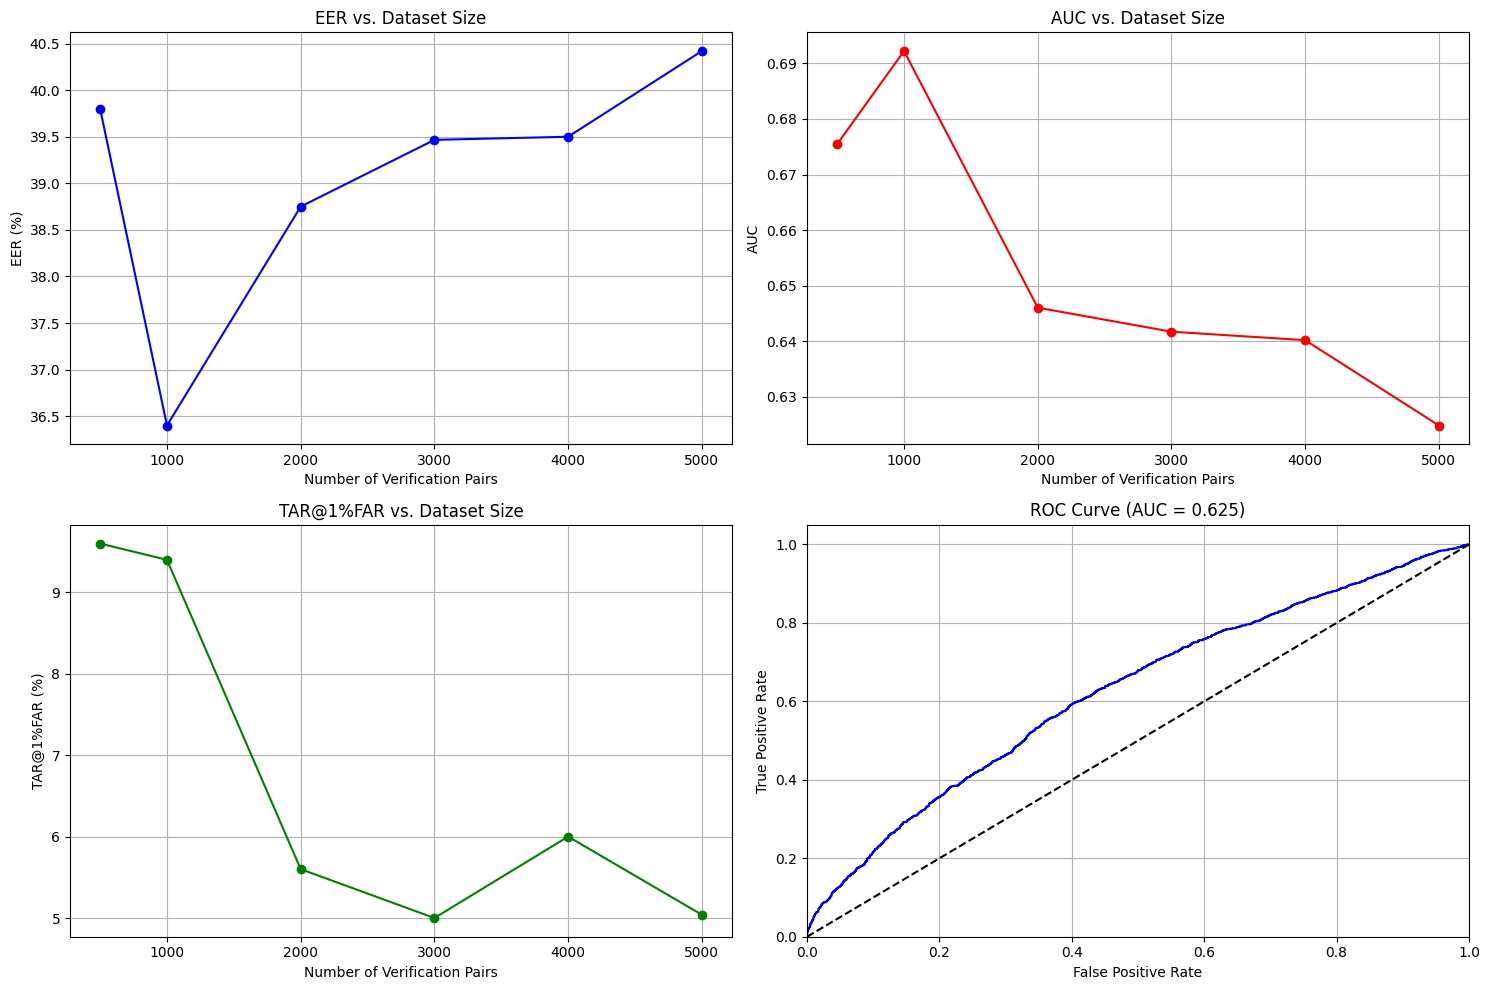


Pre-trained Model Verification Results (Full Dataset):
EER: 40.42%
TAR@1%FAR: 5.04%
AUC: 0.6249
Evaluating speaker identification accuracy...
Dataset initialized with 360 samples and 18 classes


Speaker ID Evaluation: 100%|██████████| 45/45 [00:06<00:00,  6.72it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


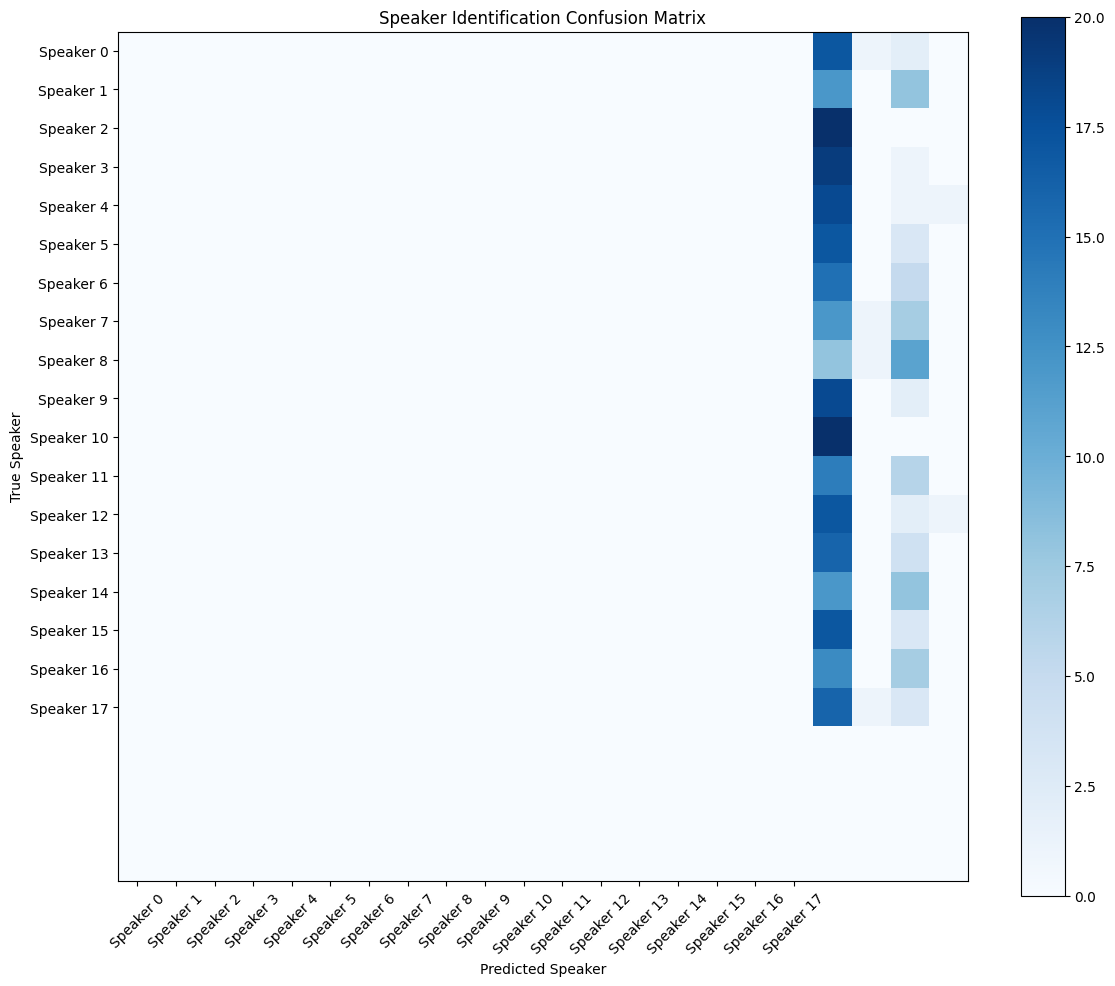

Speaker Identification Results:
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Fine-tuning model with ArcFace loss
Fine-tuning model with ArcFace loss: microsoft/wavlm-base-plus
Dataset initialized with 2000 samples and 100 classes
Dataset initialized with 360 samples and 18 classes


Epoch 1 Training:   4%|▍         | 11/250 [00:03<00:41,  5.83it/s]

Step 10/250, Loss: 20.2449


Epoch 1 Training:   8%|▊         | 21/250 [00:04<00:38,  5.91it/s]

Step 20/250, Loss: 20.2766


Epoch 1 Training:  12%|█▏        | 31/250 [00:06<00:37,  5.78it/s]

Step 30/250, Loss: 19.8219


Epoch 1 Training:  16%|█▋        | 41/250 [00:08<00:37,  5.54it/s]

Step 40/250, Loss: 21.1540


Epoch 1 Training:  20%|██        | 51/250 [00:09<00:32,  6.04it/s]

Step 50/250, Loss: 19.2682


Epoch 1 Training:  24%|██▍       | 61/250 [00:11<00:31,  6.01it/s]

Step 60/250, Loss: 19.6011


Epoch 1 Training:  28%|██▊       | 71/250 [00:13<00:29,  6.07it/s]

Step 70/250, Loss: 19.9856


Epoch 1 Training:  32%|███▏      | 81/250 [00:14<00:28,  5.93it/s]

Step 80/250, Loss: 20.1060


Epoch 1 Training:  36%|███▋      | 91/250 [00:16<00:26,  5.94it/s]

Step 90/250, Loss: 20.2589


Epoch 1 Training:  40%|████      | 101/250 [00:18<00:23,  6.28it/s]

Step 100/250, Loss: 20.2621


Epoch 1 Training:  44%|████▍     | 111/250 [00:19<00:23,  5.83it/s]

Step 110/250, Loss: 20.1358


Epoch 1 Training:  48%|████▊     | 120/250 [00:21<00:24,  5.37it/s]

Step 120/250, Loss: 19.2446


Epoch 1 Training:  52%|█████▏    | 131/250 [00:23<00:21,  5.55it/s]

Step 130/250, Loss: 20.3672


Epoch 1 Training:  56%|█████▋    | 141/250 [00:25<00:18,  6.03it/s]

Step 140/250, Loss: 19.5116


Epoch 1 Training:  60%|██████    | 151/250 [00:26<00:16,  6.15it/s]

Step 150/250, Loss: 19.5972


Epoch 1 Training:  64%|██████▍   | 161/250 [00:28<00:14,  6.08it/s]

Step 160/250, Loss: 19.4451


Epoch 1 Training:  68%|██████▊   | 171/250 [00:30<00:13,  6.04it/s]

Step 170/250, Loss: 19.5302


Epoch 1 Training:  72%|███████▏  | 181/250 [00:32<00:11,  6.10it/s]

Step 180/250, Loss: 20.0635


Epoch 1 Training:  76%|███████▋  | 191/250 [00:33<00:10,  5.81it/s]

Step 190/250, Loss: 19.7690


Epoch 1 Training:  80%|████████  | 201/250 [00:35<00:08,  5.83it/s]

Step 200/250, Loss: 19.9234


Epoch 1 Training:  84%|████████▍ | 211/250 [00:37<00:07,  5.53it/s]

Step 210/250, Loss: 19.6429


Epoch 1 Training:  88%|████████▊ | 221/250 [00:38<00:04,  5.81it/s]

Step 220/250, Loss: 19.2461


Epoch 1 Training:  92%|█████████▏| 231/250 [00:40<00:03,  6.08it/s]

Step 230/250, Loss: 20.0164


Epoch 1 Training:  96%|█████████▋| 241/250 [00:42<00:01,  6.44it/s]

Step 240/250, Loss: 19.3434


Epoch 1 Training: 100%|██████████| 250/250 [00:43<00:00,  5.71it/s]


Step 250/250, Loss: 19.4029


Validation: 100%|██████████| 45/45 [00:08<00:00,  5.56it/s]


Epoch 1/10 - Train Loss: 19.9484, Train Acc: 0.0000, Val Loss: 4.6362, Val Acc: 0.0167
Saved best model with validation accuracy: 0.0167


Epoch 2 Training:   4%|▍         | 11/250 [00:02<00:39,  6.12it/s]

Step 10/250, Loss: 19.2708


Epoch 2 Training:   8%|▊         | 21/250 [00:03<00:38,  5.99it/s]

Step 20/250, Loss: 19.9008


Epoch 2 Training:  12%|█▏        | 31/250 [00:05<00:35,  6.12it/s]

Step 30/250, Loss: 19.4029


Epoch 2 Training:  16%|█▋        | 41/250 [00:06<00:33,  6.15it/s]

Step 40/250, Loss: 18.9414


Epoch 2 Training:  20%|██        | 51/250 [00:08<00:31,  6.38it/s]

Step 50/250, Loss: 19.8228


Epoch 2 Training:  24%|██▍       | 61/250 [00:10<00:32,  5.86it/s]

Step 60/250, Loss: 18.9683


Epoch 2 Training:  28%|██▊       | 71/250 [00:12<00:30,  5.91it/s]

Step 70/250, Loss: 19.3103


Epoch 2 Training:  32%|███▏      | 81/250 [00:13<00:27,  6.11it/s]

Step 80/250, Loss: 19.2832


Epoch 2 Training:  36%|███▋      | 91/250 [00:15<00:25,  6.12it/s]

Step 90/250, Loss: 19.6135


Epoch 2 Training:  40%|████      | 101/250 [00:16<00:24,  6.03it/s]

Step 100/250, Loss: 18.9606


Epoch 2 Training:  44%|████▍     | 111/250 [00:18<00:22,  6.12it/s]

Step 110/250, Loss: 19.3199


Epoch 2 Training:  48%|████▊     | 121/250 [00:20<00:21,  5.99it/s]

Step 120/250, Loss: 19.3754


Epoch 2 Training:  52%|█████▏    | 131/250 [00:21<00:20,  5.85it/s]

Step 130/250, Loss: 19.5517


Epoch 2 Training:  56%|█████▋    | 141/250 [00:23<00:18,  5.89it/s]

Step 140/250, Loss: 19.9671


Epoch 2 Training:  60%|██████    | 151/250 [00:25<00:17,  5.69it/s]

Step 150/250, Loss: 19.7173


Epoch 2 Training:  64%|██████▍   | 161/250 [00:27<00:15,  5.89it/s]

Step 160/250, Loss: 19.8445


Epoch 2 Training:  68%|██████▊   | 171/250 [00:28<00:13,  5.96it/s]

Step 170/250, Loss: 18.9785


Epoch 2 Training:  72%|███████▏  | 181/250 [00:30<00:11,  6.05it/s]

Step 180/250, Loss: 18.9941


Epoch 2 Training:  76%|███████▋  | 191/250 [00:32<00:09,  5.95it/s]

Step 190/250, Loss: 19.4842


Epoch 2 Training:  80%|████████  | 201/250 [00:33<00:08,  6.12it/s]

Step 200/250, Loss: 18.2779


Epoch 2 Training:  84%|████████▍ | 211/250 [00:35<00:06,  6.21it/s]

Step 210/250, Loss: 19.3530


Epoch 2 Training:  88%|████████▊ | 221/250 [00:36<00:04,  6.02it/s]

Step 220/250, Loss: 18.3641


Epoch 2 Training:  92%|█████████▏| 231/250 [00:38<00:03,  5.64it/s]

Step 230/250, Loss: 18.9735


Epoch 2 Training:  96%|█████████▋| 241/250 [00:40<00:01,  5.76it/s]

Step 240/250, Loss: 19.3587


Epoch 2 Training: 100%|██████████| 250/250 [00:42<00:00,  5.95it/s]


Step 250/250, Loss: 19.4077


Validation: 100%|██████████| 45/45 [00:07<00:00,  5.65it/s]


Epoch 2/10 - Train Loss: 19.1421, Train Acc: 0.0000, Val Loss: 4.6456, Val Acc: 0.0111


Epoch 3 Training:   4%|▍         | 11/250 [00:02<00:41,  5.76it/s]

Step 10/250, Loss: 18.6444


Epoch 3 Training:   8%|▊         | 21/250 [00:03<00:39,  5.73it/s]

Step 20/250, Loss: 19.2200


Epoch 3 Training:  12%|█▏        | 31/250 [00:05<00:38,  5.76it/s]

Step 30/250, Loss: 18.2460


Epoch 3 Training:  16%|█▋        | 41/250 [00:07<00:33,  6.28it/s]

Step 40/250, Loss: 18.4377


Epoch 3 Training:  20%|██        | 51/250 [00:08<00:33,  5.91it/s]

Step 50/250, Loss: 18.9122


Epoch 3 Training:  24%|██▍       | 61/250 [00:10<00:31,  6.10it/s]

Step 60/250, Loss: 18.4799


Epoch 3 Training:  28%|██▊       | 71/250 [00:12<00:29,  6.11it/s]

Step 70/250, Loss: 18.3794


Epoch 3 Training:  32%|███▏      | 81/250 [00:13<00:28,  6.03it/s]

Step 80/250, Loss: 19.4488


Epoch 3 Training:  36%|███▋      | 91/250 [00:15<00:26,  5.93it/s]

Step 90/250, Loss: 19.2021


Epoch 3 Training:  40%|████      | 101/250 [00:17<00:26,  5.66it/s]

Step 100/250, Loss: 18.4439


Epoch 3 Training:  44%|████▍     | 111/250 [00:18<00:24,  5.62it/s]

Step 110/250, Loss: 18.7615


Epoch 3 Training:  48%|████▊     | 121/250 [00:20<00:21,  5.90it/s]

Step 120/250, Loss: 18.4483


Epoch 3 Training:  52%|█████▏    | 131/250 [00:22<00:19,  6.12it/s]

Step 130/250, Loss: 19.0440


Epoch 3 Training:  56%|█████▋    | 141/250 [00:23<00:18,  5.99it/s]

Step 140/250, Loss: 18.6876


Epoch 3 Training:  60%|██████    | 151/250 [00:25<00:16,  6.01it/s]

Step 150/250, Loss: 19.1688


Epoch 3 Training:  64%|██████▍   | 161/250 [00:27<00:14,  6.01it/s]

Step 160/250, Loss: 18.6668


Epoch 3 Training:  68%|██████▊   | 171/250 [00:28<00:13,  5.89it/s]

Step 170/250, Loss: 19.9307


Epoch 3 Training:  72%|███████▏  | 181/250 [00:30<00:11,  6.07it/s]

Step 180/250, Loss: 17.5754


Epoch 3 Training:  76%|███████▋  | 191/250 [00:32<00:10,  5.74it/s]

Step 190/250, Loss: 18.3189


Epoch 3 Training:  80%|████████  | 201/250 [00:34<00:09,  5.16it/s]

Step 200/250, Loss: 18.6497


Epoch 3 Training:  84%|████████▍ | 211/250 [00:35<00:06,  6.20it/s]

Step 210/250, Loss: 18.6839


Epoch 3 Training:  88%|████████▊ | 221/250 [00:37<00:04,  6.34it/s]

Step 220/250, Loss: 19.1129


Epoch 3 Training:  92%|█████████▏| 231/250 [00:39<00:03,  6.07it/s]

Step 230/250, Loss: 18.6780


Epoch 3 Training:  96%|█████████▋| 241/250 [00:40<00:01,  6.11it/s]

Step 240/250, Loss: 18.3733


Epoch 3 Training: 100%|██████████| 250/250 [00:42<00:00,  5.90it/s]


Step 250/250, Loss: 18.7615


Validation: 100%|██████████| 45/45 [00:08<00:00,  5.56it/s]


Epoch 3/10 - Train Loss: 18.6584, Train Acc: 0.0000, Val Loss: 4.6620, Val Acc: 0.0111


Epoch 4 Training:   4%|▍         | 11/250 [00:02<00:39,  6.04it/s]

Step 10/250, Loss: 18.3537


Epoch 4 Training:   8%|▊         | 21/250 [00:03<00:38,  5.96it/s]

Step 20/250, Loss: 18.2745


Epoch 4 Training:  12%|█▏        | 31/250 [00:05<00:35,  6.25it/s]

Step 30/250, Loss: 17.5022


Epoch 4 Training:  16%|█▋        | 41/250 [00:07<00:34,  6.05it/s]

Step 40/250, Loss: 18.4892


Epoch 4 Training:  20%|██        | 51/250 [00:08<00:32,  6.18it/s]

Step 50/250, Loss: 18.1242


Epoch 4 Training:  24%|██▍       | 61/250 [00:10<00:32,  5.85it/s]

Step 60/250, Loss: 19.1453


Epoch 4 Training:  28%|██▊       | 71/250 [00:12<00:31,  5.71it/s]

Step 70/250, Loss: 17.6245


Epoch 4 Training:  32%|███▏      | 81/250 [00:13<00:28,  6.01it/s]

Step 80/250, Loss: 18.0695


Epoch 4 Training:  36%|███▋      | 91/250 [00:15<00:24,  6.40it/s]

Step 90/250, Loss: 17.9959


Epoch 4 Training:  40%|████      | 101/250 [00:16<00:24,  6.14it/s]

Step 100/250, Loss: 18.4217


Epoch 4 Training:  44%|████▍     | 111/250 [00:18<00:22,  6.31it/s]

Step 110/250, Loss: 18.9168


Epoch 4 Training:  48%|████▊     | 121/250 [00:20<00:20,  6.34it/s]

Step 120/250, Loss: 18.6275


Epoch 4 Training:  52%|█████▏    | 131/250 [00:21<00:19,  6.09it/s]

Step 130/250, Loss: 18.7288


Epoch 4 Training:  56%|█████▋    | 141/250 [00:23<00:19,  5.69it/s]

Step 140/250, Loss: 18.3728


Epoch 4 Training:  60%|██████    | 151/250 [00:25<00:16,  6.02it/s]

Step 150/250, Loss: 18.9640


Epoch 4 Training:  64%|██████▍   | 161/250 [00:27<00:14,  6.07it/s]

Step 160/250, Loss: 18.2916


Epoch 4 Training:  68%|██████▊   | 171/250 [00:28<00:12,  6.16it/s]

Step 170/250, Loss: 17.6200


Epoch 4 Training:  72%|███████▏  | 181/250 [00:30<00:11,  6.24it/s]

Step 180/250, Loss: 18.1148


Epoch 4 Training:  76%|███████▋  | 191/250 [00:31<00:09,  6.22it/s]

Step 190/250, Loss: 18.2309


Epoch 4 Training:  80%|████████  | 201/250 [00:33<00:07,  6.15it/s]

Step 200/250, Loss: 18.7268


Epoch 4 Training:  84%|████████▍ | 211/250 [00:35<00:06,  6.06it/s]

Step 210/250, Loss: 18.9408


Epoch 4 Training:  88%|████████▊ | 221/250 [00:36<00:04,  6.02it/s]

Step 220/250, Loss: 17.5832


Epoch 4 Training:  92%|█████████▏| 231/250 [00:38<00:03,  5.87it/s]

Step 230/250, Loss: 18.2787


Epoch 4 Training:  96%|█████████▋| 241/250 [00:40<00:01,  5.63it/s]

Step 240/250, Loss: 17.2472


Epoch 4 Training: 100%|██████████| 250/250 [00:41<00:00,  5.97it/s]


Step 250/250, Loss: 18.1741


Validation: 100%|██████████| 45/45 [00:07<00:00,  5.63it/s]


Epoch 4/10 - Train Loss: 18.2846, Train Acc: 0.0000, Val Loss: 4.6411, Val Acc: 0.0139


Epoch 5 Training:   4%|▍         | 11/250 [00:02<00:42,  5.67it/s]

Step 10/250, Loss: 18.2643


Epoch 5 Training:   8%|▊         | 21/250 [00:03<00:39,  5.79it/s]

Step 20/250, Loss: 19.2088


Epoch 5 Training:  12%|█▏        | 31/250 [00:05<00:38,  5.64it/s]

Step 30/250, Loss: 18.5063


Epoch 5 Training:  16%|█▋        | 41/250 [00:07<00:34,  6.04it/s]

Step 40/250, Loss: 18.5293


Epoch 5 Training:  20%|██        | 51/250 [00:09<00:33,  6.02it/s]

Step 50/250, Loss: 17.7587


Epoch 5 Training:  24%|██▍       | 61/250 [00:10<00:29,  6.35it/s]

Step 60/250, Loss: 17.3377


Epoch 5 Training:  28%|██▊       | 71/250 [00:12<00:29,  6.06it/s]

Step 70/250, Loss: 18.7420


Epoch 5 Training:  32%|███▏      | 81/250 [00:13<00:27,  6.14it/s]

Step 80/250, Loss: 17.3823


Epoch 5 Training:  36%|███▋      | 91/250 [00:15<00:26,  5.97it/s]

Step 90/250, Loss: 18.7584


Epoch 5 Training:  40%|████      | 101/250 [00:17<00:25,  5.85it/s]

Step 100/250, Loss: 17.5306


Epoch 5 Training:  44%|████▍     | 111/250 [00:19<00:24,  5.71it/s]

Step 110/250, Loss: 18.0793


Epoch 5 Training:  48%|████▊     | 121/250 [00:20<00:21,  5.97it/s]

Step 120/250, Loss: 17.4446


Epoch 5 Training:  52%|█████▏    | 131/250 [00:22<00:19,  6.01it/s]

Step 130/250, Loss: 17.7564


Epoch 5 Training:  56%|█████▋    | 141/250 [00:24<00:18,  5.94it/s]

Step 140/250, Loss: 17.7628


Epoch 5 Training:  60%|██████    | 151/250 [00:25<00:16,  5.99it/s]

Step 150/250, Loss: 17.4088


Epoch 5 Training:  64%|██████▍   | 161/250 [00:27<00:14,  6.17it/s]

Step 160/250, Loss: 18.0566


Epoch 5 Training:  68%|██████▊   | 171/250 [00:29<00:13,  5.78it/s]

Step 170/250, Loss: 18.8164


Epoch 5 Training:  72%|███████▏  | 181/250 [00:30<00:11,  5.75it/s]

Step 180/250, Loss: 17.8802


Epoch 5 Training:  76%|███████▋  | 191/250 [00:32<00:11,  5.34it/s]

Step 190/250, Loss: 17.9298


Epoch 5 Training:  80%|████████  | 201/250 [00:34<00:07,  6.17it/s]

Step 200/250, Loss: 17.6109


Epoch 5 Training:  84%|████████▍ | 211/250 [00:35<00:06,  6.07it/s]

Step 210/250, Loss: 18.0669


Epoch 5 Training:  88%|████████▊ | 221/250 [00:37<00:04,  6.11it/s]

Step 220/250, Loss: 17.8362


Epoch 5 Training:  92%|█████████▏| 231/250 [00:39<00:03,  6.02it/s]

Step 230/250, Loss: 17.7393


Epoch 5 Training:  96%|█████████▋| 241/250 [00:40<00:01,  5.87it/s]

Step 240/250, Loss: 18.0143


Epoch 5 Training: 100%|██████████| 250/250 [00:42<00:00,  5.89it/s]


Step 250/250, Loss: 18.9583


Validation: 100%|██████████| 45/45 [00:08<00:00,  5.59it/s]


Epoch 5/10 - Train Loss: 18.0592, Train Acc: 0.0000, Val Loss: 4.6656, Val Acc: 0.0056


Epoch 6 Training:   4%|▍         | 11/250 [00:02<00:41,  5.78it/s]

Step 10/250, Loss: 18.4106


Epoch 6 Training:   8%|▊         | 21/250 [00:03<00:38,  6.00it/s]

Step 20/250, Loss: 18.4079


Epoch 6 Training:  12%|█▏        | 31/250 [00:05<00:35,  6.16it/s]

Step 30/250, Loss: 17.4672


Epoch 6 Training:  16%|█▋        | 41/250 [00:07<00:33,  6.18it/s]

Step 40/250, Loss: 17.9091


Epoch 6 Training:  20%|██        | 51/250 [00:08<00:33,  5.86it/s]

Step 50/250, Loss: 16.9565


Epoch 6 Training:  24%|██▍       | 61/250 [00:10<00:34,  5.53it/s]

Step 60/250, Loss: 18.0920


Epoch 6 Training:  28%|██▊       | 71/250 [00:12<00:29,  6.10it/s]

Step 70/250, Loss: 18.1828


Epoch 6 Training:  32%|███▏      | 81/250 [00:13<00:27,  6.05it/s]

Step 80/250, Loss: 18.3376


Epoch 6 Training:  36%|███▋      | 91/250 [00:15<00:26,  6.05it/s]

Step 90/250, Loss: 17.8342


Epoch 6 Training:  40%|████      | 101/250 [00:17<00:24,  5.97it/s]

Step 100/250, Loss: 18.4543


Epoch 6 Training:  44%|████▍     | 111/250 [00:18<00:23,  5.96it/s]

Step 110/250, Loss: 17.5216


Epoch 6 Training:  48%|████▊     | 121/250 [00:20<00:21,  6.00it/s]

Step 120/250, Loss: 17.6426


Epoch 6 Training:  52%|█████▏    | 131/250 [00:22<00:20,  5.86it/s]

Step 130/250, Loss: 17.8825


Epoch 6 Training:  56%|█████▋    | 141/250 [00:23<00:17,  6.30it/s]

Step 140/250, Loss: 16.9039


Epoch 6 Training:  60%|██████    | 151/250 [00:25<00:16,  6.09it/s]

Step 150/250, Loss: 17.1844


Epoch 6 Training:  64%|██████▍   | 161/250 [00:27<00:14,  5.96it/s]

Step 160/250, Loss: 17.2242


Epoch 6 Training:  68%|██████▊   | 171/250 [00:28<00:12,  6.29it/s]

Step 170/250, Loss: 18.0175


Epoch 6 Training:  72%|███████▏  | 181/250 [00:30<00:11,  6.07it/s]

Step 180/250, Loss: 18.7265


Epoch 6 Training:  76%|███████▋  | 191/250 [00:32<00:09,  6.22it/s]

Step 190/250, Loss: 17.7807


Epoch 6 Training:  80%|████████  | 201/250 [00:33<00:07,  6.13it/s]

Step 200/250, Loss: 17.3854


Epoch 6 Training:  84%|████████▍ | 211/250 [00:35<00:06,  6.09it/s]

Step 210/250, Loss: 17.9765


Epoch 6 Training:  88%|████████▊ | 221/250 [00:37<00:04,  5.94it/s]

Step 220/250, Loss: 17.3579


Epoch 6 Training:  92%|█████████▏| 231/250 [00:38<00:03,  5.83it/s]

Step 230/250, Loss: 17.9877


Epoch 6 Training:  96%|█████████▋| 241/250 [00:40<00:01,  5.69it/s]

Step 240/250, Loss: 17.4265


Epoch 6 Training: 100%|██████████| 250/250 [00:42<00:00,  5.93it/s]


Step 250/250, Loss: 17.7127


Validation: 100%|██████████| 45/45 [00:07<00:00,  5.65it/s]


Epoch 6/10 - Train Loss: 17.8517, Train Acc: 0.0000, Val Loss: 4.6504, Val Acc: 0.0167


Epoch 7 Training:   4%|▍         | 11/250 [00:02<00:41,  5.76it/s]

Step 10/250, Loss: 17.7635


Epoch 7 Training:   8%|▊         | 21/250 [00:03<00:39,  5.80it/s]

Step 20/250, Loss: 17.4889


Epoch 7 Training:  12%|█▏        | 31/250 [00:05<00:35,  6.11it/s]

Step 30/250, Loss: 16.8953


Epoch 7 Training:  16%|█▋        | 41/250 [00:07<00:33,  6.16it/s]

Step 40/250, Loss: 17.7553


Epoch 7 Training:  20%|██        | 51/250 [00:08<00:34,  5.83it/s]

Step 50/250, Loss: 17.8902


Epoch 7 Training:  24%|██▍       | 61/250 [00:10<00:31,  6.07it/s]

Step 60/250, Loss: 17.9268


Epoch 7 Training:  28%|██▊       | 71/250 [00:12<00:29,  6.08it/s]

Step 70/250, Loss: 17.9072


Epoch 7 Training:  32%|███▏      | 81/250 [00:13<00:27,  6.05it/s]

Step 80/250, Loss: 17.0461


Epoch 7 Training:  36%|███▋      | 91/250 [00:15<00:25,  6.26it/s]

Step 90/250, Loss: 17.4139


Epoch 7 Training:  40%|████      | 101/250 [00:17<00:24,  6.02it/s]

Step 100/250, Loss: 18.6418


Epoch 7 Training:  44%|████▍     | 111/250 [00:18<00:23,  5.85it/s]

Step 110/250, Loss: 17.2380


Epoch 7 Training:  48%|████▊     | 121/250 [00:20<00:21,  6.04it/s]

Step 120/250, Loss: 17.2693


Epoch 7 Training:  52%|█████▏    | 131/250 [00:22<00:19,  6.07it/s]

Step 130/250, Loss: 17.1892


Epoch 7 Training:  56%|█████▋    | 141/250 [00:23<00:16,  6.55it/s]

Step 140/250, Loss: 17.0757


Epoch 7 Training:  60%|██████    | 151/250 [00:25<00:16,  5.97it/s]

Step 150/250, Loss: 17.4555


Epoch 7 Training:  64%|██████▍   | 161/250 [00:27<00:14,  6.11it/s]

Step 160/250, Loss: 17.7027


Epoch 7 Training:  68%|██████▊   | 171/250 [00:28<00:13,  5.92it/s]

Step 170/250, Loss: 18.1549


Epoch 7 Training:  72%|███████▏  | 181/250 [00:30<00:12,  5.75it/s]

Step 180/250, Loss: 17.8250


Epoch 7 Training:  76%|███████▋  | 191/250 [00:32<00:10,  5.90it/s]

Step 190/250, Loss: 17.3822


Epoch 7 Training:  80%|████████  | 201/250 [00:33<00:08,  5.98it/s]

Step 200/250, Loss: 17.7989


Epoch 7 Training:  84%|████████▍ | 211/250 [00:35<00:06,  6.32it/s]

Step 210/250, Loss: 17.9613


Epoch 7 Training:  88%|████████▊ | 221/250 [00:37<00:04,  5.93it/s]

Step 220/250, Loss: 18.0852


Epoch 7 Training:  92%|█████████▏| 231/250 [00:38<00:03,  6.03it/s]

Step 230/250, Loss: 17.8066


Epoch 7 Training:  96%|█████████▋| 241/250 [00:40<00:01,  6.01it/s]

Step 240/250, Loss: 18.3655


Epoch 7 Training: 100%|██████████| 250/250 [00:42<00:00,  5.95it/s]


Step 250/250, Loss: 18.0087


Validation: 100%|██████████| 45/45 [00:08<00:00,  5.59it/s]


Epoch 7/10 - Train Loss: 17.6908, Train Acc: 0.0000, Val Loss: 4.6405, Val Acc: 0.0167


Epoch 8 Training:   4%|▍         | 11/250 [00:02<00:40,  5.86it/s]

Step 10/250, Loss: 18.0708


Epoch 8 Training:   8%|▊         | 21/250 [00:03<00:37,  6.09it/s]

Step 20/250, Loss: 16.5810


Epoch 8 Training:  12%|█▏        | 31/250 [00:05<00:35,  6.10it/s]

Step 30/250, Loss: 17.0394


Epoch 8 Training:  16%|█▋        | 41/250 [00:07<00:34,  6.04it/s]

Step 40/250, Loss: 17.2158


Epoch 8 Training:  20%|██        | 51/250 [00:08<00:33,  5.89it/s]

Step 50/250, Loss: 18.7050


Epoch 8 Training:  24%|██▍       | 61/250 [00:10<00:32,  5.77it/s]

Step 60/250, Loss: 17.6687


Epoch 8 Training:  28%|██▊       | 71/250 [00:12<00:31,  5.63it/s]

Step 70/250, Loss: 17.0307


Epoch 8 Training:  32%|███▏      | 81/250 [00:13<00:28,  5.85it/s]

Step 80/250, Loss: 17.4007


Epoch 8 Training:  36%|███▋      | 91/250 [00:15<00:26,  5.93it/s]

Step 90/250, Loss: 16.9716


Epoch 8 Training:  40%|████      | 101/250 [00:17<00:24,  6.02it/s]

Step 100/250, Loss: 17.5664


Epoch 8 Training:  44%|████▍     | 111/250 [00:18<00:23,  5.99it/s]

Step 110/250, Loss: 18.5990


Epoch 8 Training:  48%|████▊     | 121/250 [00:20<00:21,  6.06it/s]

Step 120/250, Loss: 18.1053


Epoch 8 Training:  52%|█████▏    | 131/250 [00:22<00:19,  6.24it/s]

Step 130/250, Loss: 17.7986


Epoch 8 Training:  56%|█████▋    | 141/250 [00:23<00:19,  5.69it/s]

Step 140/250, Loss: 17.7454


Epoch 8 Training:  60%|██████    | 151/250 [00:25<00:17,  5.59it/s]

Step 150/250, Loss: 17.8366


Epoch 8 Training:  64%|██████▍   | 161/250 [00:27<00:15,  5.93it/s]

Step 160/250, Loss: 18.6455


Epoch 8 Training:  68%|██████▊   | 171/250 [00:28<00:12,  6.16it/s]

Step 170/250, Loss: 18.1203


Epoch 8 Training:  72%|███████▏  | 181/250 [00:30<00:11,  5.94it/s]

Step 180/250, Loss: 18.1040


Epoch 8 Training:  76%|███████▋  | 191/250 [00:32<00:09,  6.00it/s]

Step 190/250, Loss: 17.5565


Epoch 8 Training:  80%|████████  | 201/250 [00:33<00:08,  6.01it/s]

Step 200/250, Loss: 17.8461


Epoch 8 Training:  84%|████████▍ | 211/250 [00:35<00:06,  6.00it/s]

Step 210/250, Loss: 17.4723


Epoch 8 Training:  88%|████████▊ | 221/250 [00:37<00:04,  5.98it/s]

Step 220/250, Loss: 18.3279


Epoch 8 Training:  92%|█████████▏| 231/250 [00:38<00:03,  5.82it/s]

Step 230/250, Loss: 17.1897


Epoch 8 Training:  96%|█████████▋| 241/250 [00:40<00:01,  5.90it/s]

Step 240/250, Loss: 17.1491


Epoch 8 Training: 100%|██████████| 250/250 [00:42<00:00,  5.91it/s]


Step 250/250, Loss: 17.1239


Validation: 100%|██████████| 45/45 [00:07<00:00,  5.66it/s]


Epoch 8/10 - Train Loss: 17.6049, Train Acc: 0.0000, Val Loss: 4.6571, Val Acc: 0.0111


Epoch 9 Training:   4%|▍         | 11/250 [00:02<00:41,  5.79it/s]

Step 10/250, Loss: 17.4561


Epoch 9 Training:   8%|▊         | 21/250 [00:03<00:38,  5.93it/s]

Step 20/250, Loss: 16.5900


Epoch 9 Training:  12%|█▏        | 31/250 [00:05<00:38,  5.66it/s]

Step 30/250, Loss: 16.3343


Epoch 9 Training:  16%|█▋        | 41/250 [00:07<00:34,  6.07it/s]

Step 40/250, Loss: 17.1588


Epoch 9 Training:  20%|██        | 51/250 [00:08<00:33,  5.87it/s]

Step 50/250, Loss: 17.2167


Epoch 9 Training:  24%|██▍       | 61/250 [00:10<00:31,  5.93it/s]

Step 60/250, Loss: 17.8614


Epoch 9 Training:  28%|██▊       | 71/250 [00:12<00:29,  6.01it/s]

Step 70/250, Loss: 18.2706


Epoch 9 Training:  32%|███▏      | 81/250 [00:13<00:28,  6.00it/s]

Step 80/250, Loss: 17.2144


Epoch 9 Training:  36%|███▋      | 91/250 [00:15<00:26,  6.10it/s]

Step 90/250, Loss: 17.4318


Epoch 9 Training:  40%|████      | 101/250 [00:17<00:26,  5.68it/s]

Step 100/250, Loss: 16.9221


Epoch 9 Training:  44%|████▍     | 111/250 [00:18<00:23,  5.87it/s]

Step 110/250, Loss: 16.9955


Epoch 9 Training:  48%|████▊     | 121/250 [00:20<00:21,  6.01it/s]

Step 120/250, Loss: 17.7570


Epoch 9 Training:  52%|█████▏    | 131/250 [00:22<00:19,  5.96it/s]

Step 130/250, Loss: 17.9083


Epoch 9 Training:  56%|█████▋    | 141/250 [00:23<00:18,  5.99it/s]

Step 140/250, Loss: 17.1837


Epoch 9 Training:  60%|██████    | 151/250 [00:25<00:16,  6.10it/s]

Step 150/250, Loss: 17.7085


Epoch 9 Training:  64%|██████▍   | 161/250 [00:27<00:14,  5.97it/s]

Step 160/250, Loss: 18.1370


Epoch 9 Training:  68%|██████▊   | 171/250 [00:28<00:13,  6.08it/s]

Step 170/250, Loss: 17.5505


Epoch 9 Training:  72%|███████▏  | 181/250 [00:30<00:11,  6.02it/s]

Step 180/250, Loss: 17.1994


Epoch 9 Training:  76%|███████▋  | 191/250 [00:32<00:10,  5.52it/s]

Step 190/250, Loss: 17.6835


Epoch 9 Training:  80%|████████  | 201/250 [00:33<00:08,  5.95it/s]

Step 200/250, Loss: 17.5410


Epoch 9 Training:  84%|████████▍ | 211/250 [00:35<00:06,  5.88it/s]

Step 210/250, Loss: 17.9156


Epoch 9 Training:  88%|████████▊ | 221/250 [00:37<00:04,  6.05it/s]

Step 220/250, Loss: 17.4053


Epoch 9 Training:  92%|█████████▏| 231/250 [00:38<00:03,  6.15it/s]

Step 230/250, Loss: 18.1543


Epoch 9 Training:  96%|█████████▋| 241/250 [00:40<00:01,  5.94it/s]

Step 240/250, Loss: 17.1930


Epoch 9 Training: 100%|██████████| 250/250 [00:42<00:00,  5.93it/s]


Step 250/250, Loss: 17.1208


Validation: 100%|██████████| 45/45 [00:08<00:00,  5.62it/s]


Epoch 9/10 - Train Loss: 17.6170, Train Acc: 0.0000, Val Loss: 4.6418, Val Acc: 0.0111


Epoch 10 Training:   4%|▍         | 11/250 [00:02<00:40,  5.95it/s]

Step 10/250, Loss: 17.3831


Epoch 10 Training:   8%|▊         | 21/250 [00:03<00:38,  5.90it/s]

Step 20/250, Loss: 17.2379


Epoch 10 Training:  12%|█▏        | 31/250 [00:05<00:36,  5.99it/s]

Step 30/250, Loss: 17.6081


Epoch 10 Training:  16%|█▋        | 41/250 [00:07<00:34,  6.03it/s]

Step 40/250, Loss: 17.9317


Epoch 10 Training:  20%|██        | 51/250 [00:08<00:34,  5.83it/s]

Step 50/250, Loss: 16.9399


Epoch 10 Training:  24%|██▍       | 61/250 [00:10<00:32,  5.86it/s]

Step 60/250, Loss: 18.0380


Epoch 10 Training:  28%|██▊       | 71/250 [00:12<00:29,  6.15it/s]

Step 70/250, Loss: 18.2380


Epoch 10 Training:  32%|███▏      | 81/250 [00:13<00:28,  5.91it/s]

Step 80/250, Loss: 17.5835


Epoch 10 Training:  36%|███▋      | 91/250 [00:15<00:26,  5.90it/s]

Step 90/250, Loss: 17.4761


Epoch 10 Training:  40%|████      | 101/250 [00:17<00:24,  6.09it/s]

Step 100/250, Loss: 17.7283


Epoch 10 Training:  44%|████▍     | 111/250 [00:18<00:22,  6.05it/s]

Step 110/250, Loss: 18.5708


Epoch 10 Training:  48%|████▊     | 121/250 [00:20<00:20,  6.19it/s]

Step 120/250, Loss: 17.3034


Epoch 10 Training:  52%|█████▏    | 131/250 [00:22<00:19,  6.10it/s]

Step 130/250, Loss: 17.4480


Epoch 10 Training:  56%|█████▋    | 141/250 [00:23<00:19,  5.67it/s]

Step 140/250, Loss: 17.6272


Epoch 10 Training:  60%|██████    | 151/250 [00:25<00:17,  5.60it/s]

Step 150/250, Loss: 16.6507


Epoch 10 Training:  64%|██████▍   | 161/250 [00:27<00:14,  6.23it/s]

Step 160/250, Loss: 17.3877


Epoch 10 Training:  68%|██████▊   | 171/250 [00:29<00:13,  6.04it/s]

Step 170/250, Loss: 17.8513


Epoch 10 Training:  72%|███████▏  | 181/250 [00:30<00:11,  6.23it/s]

Step 180/250, Loss: 17.2186


Epoch 10 Training:  76%|███████▋  | 191/250 [00:32<00:09,  6.22it/s]

Step 190/250, Loss: 17.7320


Epoch 10 Training:  80%|████████  | 201/250 [00:33<00:07,  6.36it/s]

Step 200/250, Loss: 16.8176


Epoch 10 Training:  84%|████████▍ | 211/250 [00:35<00:06,  6.25it/s]

Step 210/250, Loss: 16.8412


Epoch 10 Training:  88%|████████▊ | 221/250 [00:37<00:04,  5.99it/s]

Step 220/250, Loss: 17.3506


Epoch 10 Training:  92%|█████████▏| 231/250 [00:38<00:03,  5.77it/s]

Step 230/250, Loss: 17.3725


Epoch 10 Training:  96%|█████████▋| 241/250 [00:40<00:01,  5.90it/s]

Step 240/250, Loss: 17.2549


Epoch 10 Training: 100%|██████████| 250/250 [00:42<00:00,  5.92it/s]


Step 250/250, Loss: 17.1885


Validation: 100%|██████████| 45/45 [00:07<00:00,  5.69it/s]


Epoch 10/10 - Train Loss: 17.5384, Train Acc: 0.0000, Val Loss: 4.6443, Val Acc: 0.0139


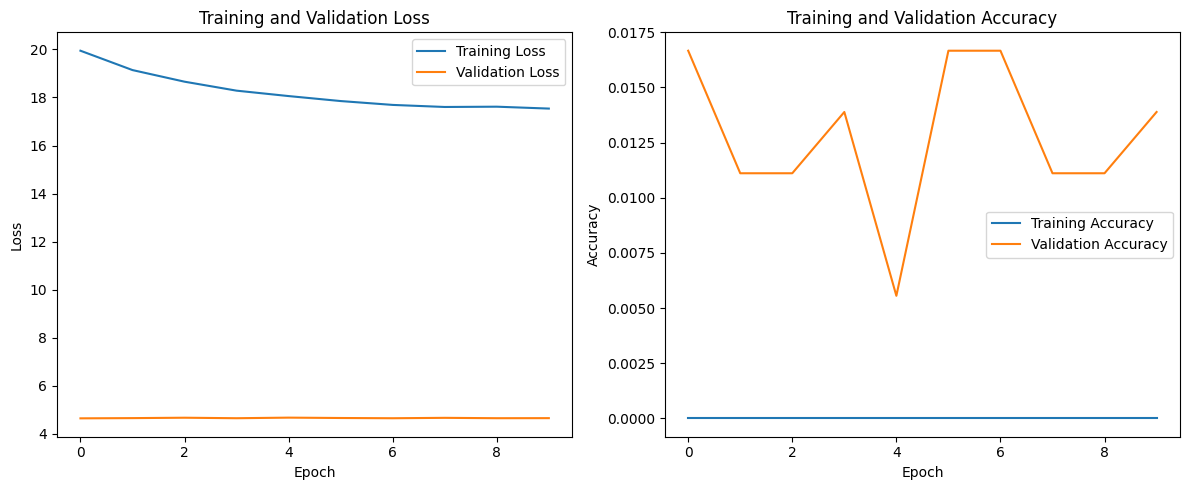


Evaluating fine-tuned model
Evaluating fine-tuned model on verification task
Verification dataset initialized with 37720 pairs


Verification Evaluation: 100%|██████████| 4715/4715 [26:33<00:00,  2.96it/s]



Fine-tuned Model Verification Results:
EER: 40.43%
TAR@1%FAR: 4.10%
AUC: 0.6324


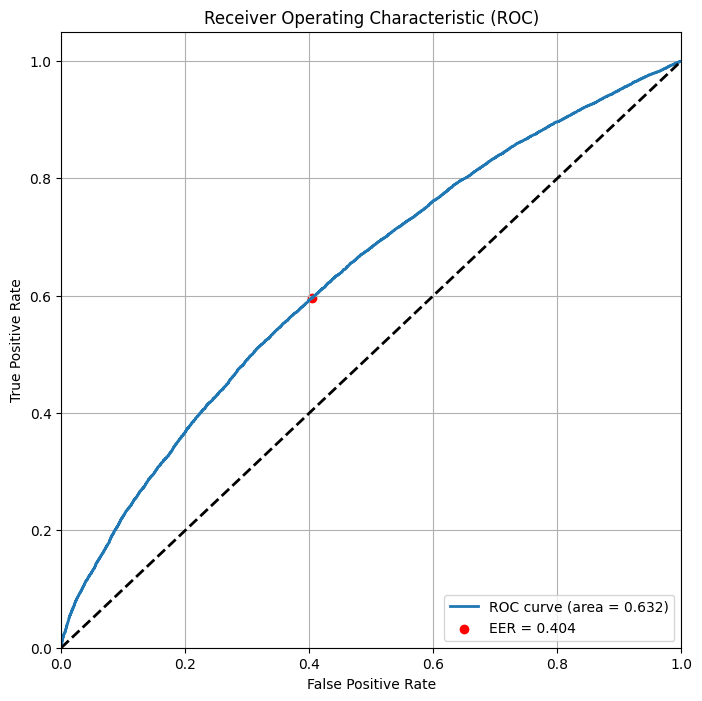

Evaluating speaker identification accuracy...
Dataset initialized with 360 samples and 18 classes


Speaker ID Evaluation: 100%|██████████| 45/45 [00:08<00:00,  5.55it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


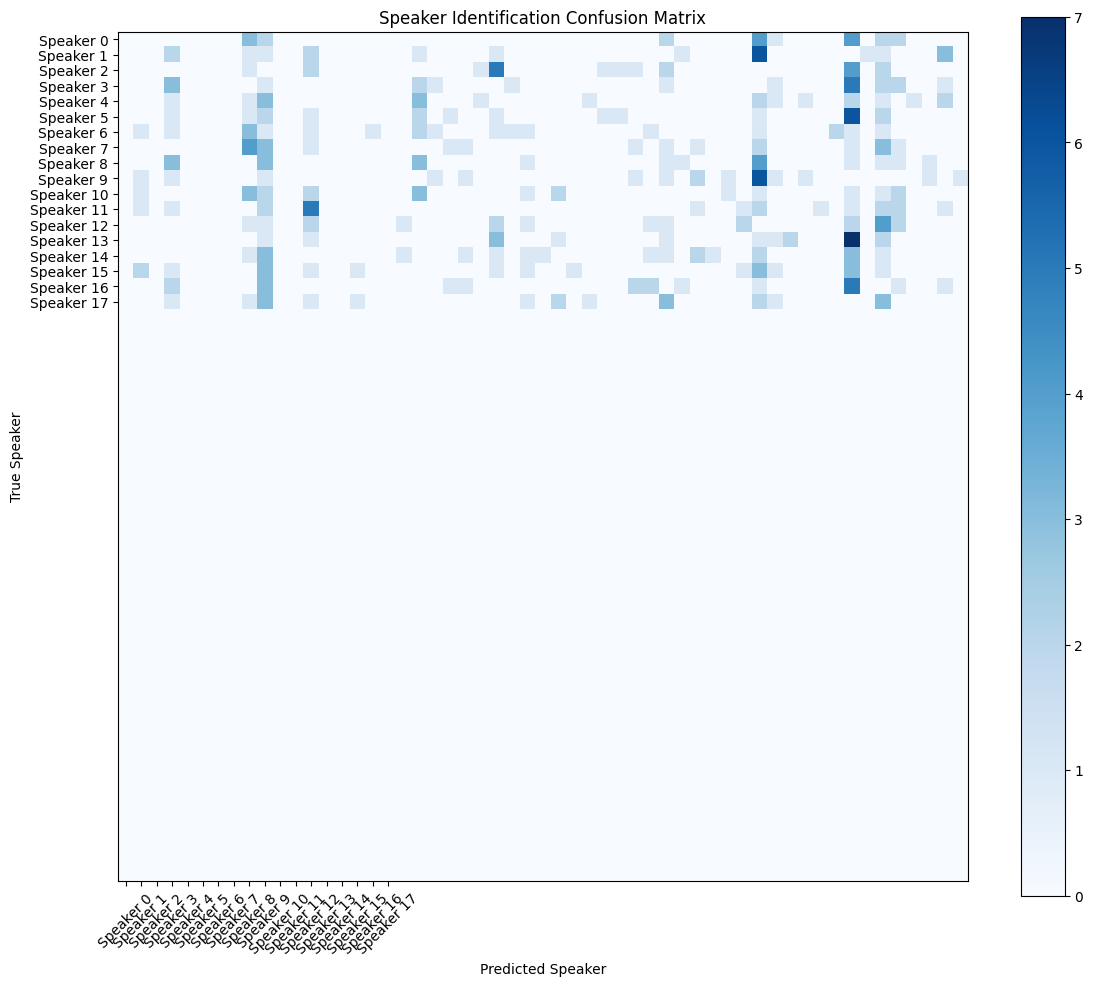

Speaker Identification Results:
Accuracy: 0.0194
Precision: 0.0450
Recall: 0.0194
F1 Score: 0.0218

Saving models and results
Could not save full models due to serialization limitations: Serialization of parametrized modules is only supported through state_dict(). See:
https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training
Model weights have been saved successfully using state_dict()
Models and metrics saved to /content/model_outputs

Comparing model performance

Model Performance Comparison
Metric          Pre-trained     Fine-tuned      Improvement    
------------------------------------------------------------
EER (%)         40.42           40.43           -0.01          
TAR@1%FAR (%)   5.04            4.10            -0.94          
AUC             0.6249          0.6324          0.0076         

Speaker Identification Performance Comparison
Metric          Pre-trained     Fine-tuned      Impro

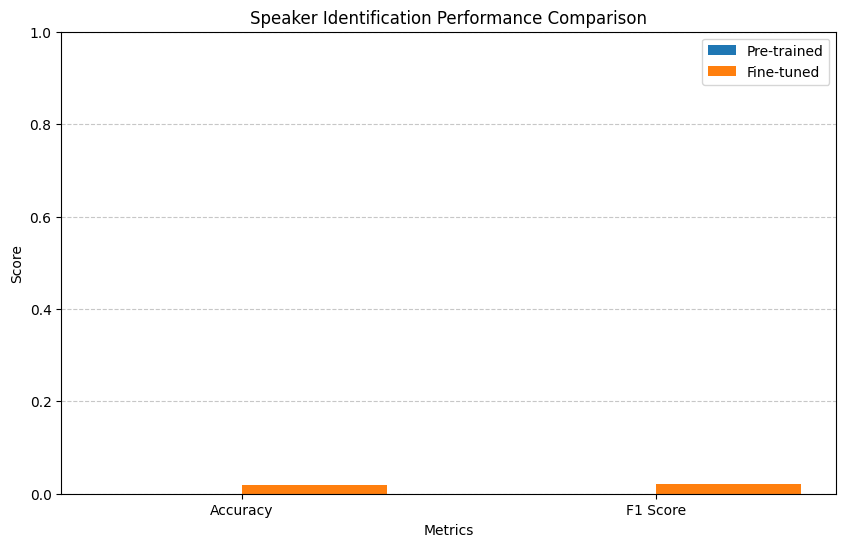

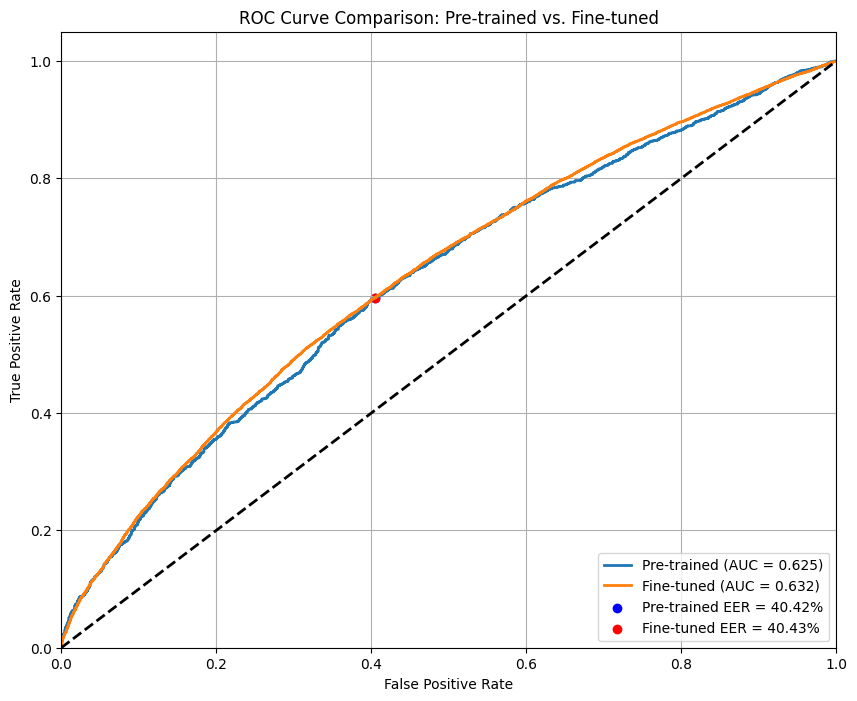

In [44]:
# Example usage:
results = run_speaker_verification_experiment(num_epochs = 10, save_dir='/content/model_outputs')

In [45]:
!zip -r SU2_models.zip model_checkpoints model_outputs plots

  adding: model_checkpoints/ (stored 0%)
  adding: model_checkpoints/model_arcface_best.pt (deflated 41%)
  adding: model_outputs/ (stored 0%)
  adding: model_outputs/pretrained_metrics.json (deflated 49%)
  adding: model_outputs/pretrained_model_full.pt (deflated 63%)
  adding: model_outputs/finetuned_metrics.pkl (deflated 66%)
  adding: model_outputs/pretrained_model_weights.pt (deflated 41%)
  adding: model_outputs/finetuned_model_weights.pt (deflated 41%)
  adding: model_outputs/finetuned_metrics.json (deflated 55%)
  adding: model_outputs/plots/ (stored 0%)
  adding: model_outputs/plots/model_comparison_roc.png (deflated 14%)
  adding: model_outputs/plots/speaker_id_comparison.png (deflated 30%)
  adding: model_outputs/plots/pretrained_model_evaluation.png (deflated 17%)
  adding: model_outputs/plots/speaker_id_confusion_matrix.png (deflated 31%)
  adding: model_outputs/plots/verification_roc.png (deflated 16%)
  adding: model_outputs/pretrained_metrics.pkl (deflated 72%)
  adding

In [46]:
from google.colab import files
files.download('SU2_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>